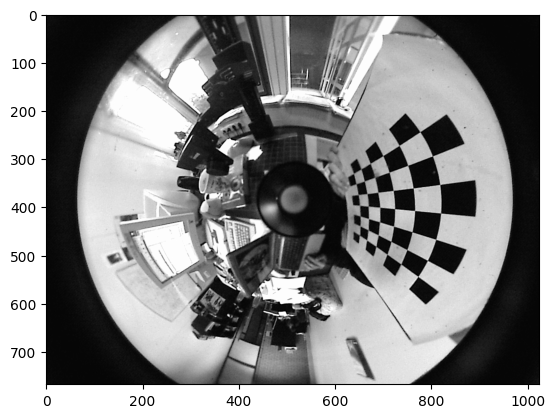

In [111]:
import pathlib
import cv2
from matplotlib import pyplot as plt
import numpy as np

checkboard_size = (7, 4)

def read_images(path: str) -> tuple[list, list]:
    path = pathlib.Path(path)
    images = []
    gray_images = []
    for image_path in path.glob('*.jpg'):
        image = cv2.imread(str(image_path))

        images.append(image)
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_images.append(gray_image)
    return (images, gray_images)

images, gray_images = read_images('referenceData/OcamCalib')
plt.imshow(gray_images[0], cmap='gray')

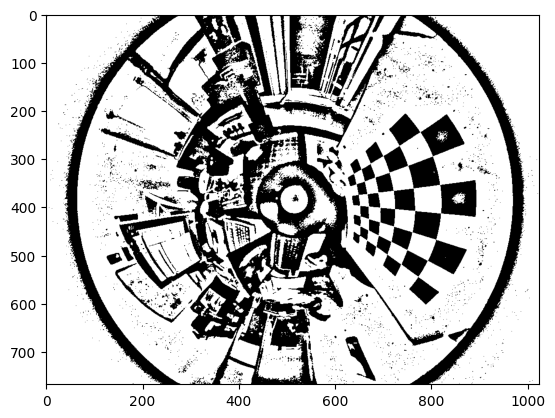

In [112]:
def calculate_adaptive_threshold_kernel_size(img: np.ndarray) -> int:
    # Calculate the kernel size for adaptive thresholding
    # based on the image size
    height, width = img.shape
    kernel_size = int(height * width / 10000)
    if kernel_size % 2 == 0:
        kernel_size += 1
    return kernel_size

binary_images = []
for image in gray_images:
    # Apply thresholding
    kernel_size = calculate_adaptive_threshold_kernel_size(image)
    binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, kernel_size, 5)
    binary_images.append(binary)

plt.imshow(binary_images[0], cmap='gray')

In [113]:
def dilate(img: np.ndarray, kernel="rect", iterations=1) -> np.ndarray:
    if kernel == "cross":
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    elif kernel == "rect":
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    elif kernel == "ellipse":
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    else:
        raise ValueError("Unknown kernel type")
    return cv2.dilate(img, kernel, iterations=iterations)

In [114]:
class Quadrangle:
    def __init__(self, points: list[tuple[int, int]]):
        self.points = points.squeeze()
        self.center = self._calculate_center(self.points)
        self.min_edge_length = self._calculate_min_edge_length(self.points)

    def is_similar_to(self, other: "Quadrangle", epsilon: float) -> bool:
        # Check if the points are similar
        center_1 = self.center
        center_2 = other.center
        center_distance = np.linalg.norm(center_1 - center_2)

        perimeter_1 = self.get_arch_length()
        perimeter_2 = other.get_arch_length()
        perimeter_distance = np.abs(perimeter_1 - perimeter_2)

        return center_distance < epsilon or perimeter_distance < epsilon
        
    def get_arch_length(self) -> float:
        return cv2.arcLength(self.points, True)
    
    def get_point_pairs_can_be_linked(self, other: "Quadrangle") -> list[tuple[np.ndarray, np.ndarray]]:
        indices = self.get_point_indices_close_enough_to_link(other)

        index_pairs = zip(indices[0], indices[1])

        point_pairs = []
        for p1_idx, p2_idx in index_pairs:
            if are_points_on_the_near_side_of_quadrangles(self, p1_idx, other, p2_idx):
                point_pairs.append((self.points[p1_idx], other.points[p2_idx]))

        return point_pairs

    def get_point_indices_close_enough_to_link(self, other: "Quadrangle") -> tuple[np.ndarray, np.ndarray]:
        distance_mat = self.get_distances_between_all_points(other)
        threshold = min(self.min_edge_length, other.min_edge_length)
        indices = np.where(distance_mat < threshold)
        # rows: indices of self.points
        # cols: indices of other.points
        return indices

    # def is_close_enough_to_link(self, other) -> bool:
    #     distance_mat = self.get_distances_between_all_points(other)
    #     min_distance = distance_mat.min()
    #     return min_distance < self.min_edge_length or min_distance < other.min_edge_length

    def get_distances_between_all_points(self, other: "Quadrangle") -> np.ndarray:
        
        this_points = np.repeat(self.points, len(other.points), axis=0)
        other_points = np.tile(other.points, (len(self.points), 1))

        distances = np.linalg.norm(this_points - other_points, axis=1)
        distances = distances.reshape((len(self.points), len(other.points)))
        return distances

    def _calculate_center(self, points):
        center = points.mean(axis=-1).squeeze()
        return center

    def _calculate_min_edge_length(self, points):
        # Calculate the minimum edge length
        min_edge_length = np.inf
        for i in range(len(points)):
            p1 = points[i]
            p2 = points[(i + 1) % len(points)]
            edge_length = np.linalg.norm(p1 - p2)
            if edge_length < min_edge_length:
                min_edge_length = edge_length
        return min_edge_length


def are_points_on_the_near_side_of_quadrangles(quad_1: Quadrangle, point_1_idx: int, quad_2: Quadrangle, point_2_idx: int) -> bool:
    num_quad_1_points = len(quad_1.points)
    num_quad_2_points = len(quad_2.points)

    line1_s = quad_1.points[(point_1_idx + num_quad_1_points - 1) % num_quad_1_points]
    line1_e = quad_1.points[(point_1_idx + 1) % num_quad_1_points]
    line2_s = quad_2.points[(point_2_idx + num_quad_2_points - 1) % num_quad_2_points]
    line2_e = quad_2.points[(point_2_idx + 1) % num_quad_2_points]

    points_are_on_the_same_side_of_line1 = are_points_on_the_same_side_of_line(line1_s, line1_e, quad_2.points[point_2_idx], quad_1.points[point_1_idx])
    points_are_on_the_same_side_of_line2 = are_points_on_the_same_side_of_line(line2_s, line2_e, quad_1.points[point_1_idx], quad_2.points[point_2_idx])
    
    return points_are_on_the_same_side_of_line1 and points_are_on_the_same_side_of_line2

def are_points_on_the_same_side_of_line(s: np.ndarray, e: np.ndarray, p1: np.ndarray, p2: np.ndarray) -> bool:
    # Check if the points are on the same side of the line
    # connecting s and e
    # Calculate the cross product
    c1 = np.cross(e - s, p1 - s)
    c2 = np.cross(e - s, p2 - s)
    return np.dot(c1, c2) > 0

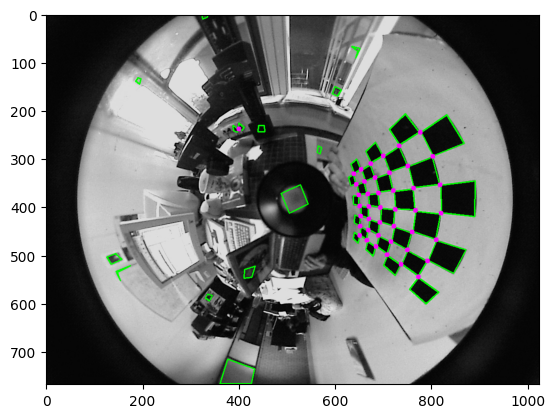

In [115]:
def find_quadrangles(img: np.ndarray, epsilon_ratio=0.1) -> list[Quadrangle]:
    quadrangles = []
    height, width = img.shape
    quadrangle_perimeter_threshold = 2 * (height + width) / 100
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        # Approximate the contour with a polygon
        perimeter = cv2.arcLength(contour, True)
        epsilon = epsilon_ratio * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)
        # If the polygon has 4 vertices, it is a quadrangle
        approx_perimeter = cv2.arcLength(approx, True)
        if approx_perimeter < quadrangle_perimeter_threshold:
            continue
        if len(approx) == 4:
            quadrangles.append(approx)

    return [Quadrangle(quadrangle) for quadrangle in quadrangles]

def draw_quadrangles(img: np.array, quadrangles: list[Quadrangle]):
    for quadrangle in quadrangles:
        cv2.drawContours(img, [quadrangle.points], 0, (0, 255, 0), 2)
    return img

def draw_links(img: np.array, links: np.ndarray):
    for link in links:
        cv2.line(img, tuple(link[0]), tuple(link[1]), (255, 0, 255), 2)
    return img

def draw_corners(img: np.array, corners: np.ndarray):
    for corner in corners:
        cv2.circle(img, corner.astype(np.int32), 5, (255, 0, 255), -1)
    return img

def remove_similar_quadrangles(quadrangles: list[Quadrangle], old_quadrangles: list[Quadrangle], epsilon: float) -> list[Quadrangle]:
    if len(old_quadrangles) == 0:
        return quadrangles

    new_quadrangles = []
    for quadrangle in quadrangles:
        is_similar = False
        for old_quadangle in old_quadrangles:
            if quadrangle.is_similar_to(old_quadangle, epsilon):
                is_similar = True
                break
        if not is_similar:
            new_quadrangles.append(quadrangle)

    return new_quadrangles

def find_corners(img: np.array, max_iterations=1) -> list[Quadrangle]:
    similar_quad_epsilon = 3
    num_corners = checkboard_size[0] * checkboard_size[1]
    all_quadrangles = []
    prev_quadrangles = []
    links = None
    for i in range(max_iterations):
        img = dilate(img)
        quadrangles = find_quadrangles(img)
        # compare the similarity with the previous iteration quadrangles, because quadrangles in the previous iteration are already included in the all_quadrangles
        new_quadrangles = remove_similar_quadrangles(
            quadrangles, prev_quadrangles, epsilon=similar_quad_epsilon
        )
        all_quadrangles += new_quadrangles
        prev_quadrangles = quadrangles
        links = link_quadrangles(all_quadrangles)
        if (len(links) >= num_corners):
            break
    return link_to_corners(links), all_quadrangles

def link_quadrangles(quadrangles) -> np.ndarray:
    # Link quadrangles to form a checkerboard
    # Return links between quadrangles

    links = []
    for quadrangle in quadrangles:
        for other_quadrangle in quadrangles:
            if quadrangle == other_quadrangle:
                continue
            _links = quadrangle.get_point_pairs_can_be_linked(other_quadrangle)
            links += _links

    return np.array(links)

def link_to_corners(links: np.ndarray):
    return links.mean(axis=1)

quad_1 = Quadrangle(np.array([[[0,0]],[[0,1]],[[1,1]],[[1,0]]]))
quad_2 = Quadrangle(np.array([[[1,1]],[[1,2]],[[2,2]],[[2,1]]]))

links = quad_1.get_point_pairs_can_be_linked(quad_2)

test_image = binary_images[0]
test_original = images[0]
corners, quadrangles = find_corners(test_image, max_iterations=5)
test_original = draw_quadrangles(test_original, quadrangles)
test_original = draw_corners(test_original, corners)
plt.imshow(test_original)